# Anomalous user detection using authentication graphs

In the previous notebook, we tried to detect compromised user accounts by applying standard anomaly detection algorithms to handcrafted feature vectors.
While we did get some encouraging results, the approach seemed to have several important flaws.
First of all, aggregating events by user and day seems to be too coarse, leading to hardly exploitable results.
Secondly, the features we extracted were rather basic, and it was not clear whether they could actually highlight malicious behavior.

In this notebook, we address this second limitation by trying to build a more expressive representation of user activity.
This representation leverages the relational nature of authentication events to represent each user-day as a graph.

In [1]:
import os
import grakel as gk
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from joblib import Parallel, delayed

from scipy.stats import entropy, pearsonr

from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

from utils import evaluate_algo, plot_examples, plot_graph_examples

In [2]:
# Helper functions
def empirical_entropy(values):
    counts = np.unique(values, return_counts=True)[1]
    return entropy(counts)

def robust_diameter(g):
    return max(
        max(nx.single_source_shortest_path_length(g, v).values())
        for v in g.nodes)

feature_names =[
    'n_vertices', 'n_arcs', 'n_cc',
    'ent_in_degrees', 'max_in_degree',
    'ent_out_degrees', 'max_out_degree',
    #'ent_weights', 'max_weight',
    'std_weights', 'max_weight',
    'diameter'
]

def graph_features(g):
    n_vertices, n_arcs = nx.number_of_nodes(g), nx.number_of_edges(g)
    n_cc = nx.number_weakly_connected_components(g)
    in_degrees = [g.in_degree(v) for v in g.nodes]
    out_degrees = [g.out_degree(v) for v in g.nodes]
    weights = [g.edges[e]['w'] for e in g.edges]
    diameter = robust_diameter(g)
    
    features = [
        n_vertices, n_arcs, n_cc,
        empirical_entropy(in_degrees), max(in_degrees),
        empirical_entropy(out_degrees), max(out_degrees),
        #empirical_entropy(weights), max(weights),
        np.std(weights), max(weights),
        diameter
    ]
    return features

def load_graph(ident):
    user, day = ident.split('_')
    fp = os.path.join(graphs_path, user, '{0}.graphml'.format(day))
    return nx.readwrite.graphml.read_graphml(fp)

def make_feature_vector(ident):
    return graph_features(load_graph(ident))

In [3]:
seed = 123
np.random.seed(seed)

In [4]:
dir_path = os.path.join('data', 'user_graphs')
graphs_path = os.path.join(dir_path, 'graphs')

The dataset now consists of labelled, weighted and directed graphs, each corresponding to the authentication events generated by one user on a given day.
More specifically, for each user-day, we collect all available authentication events and abstract them into a graph whose vertices are hosts (labelled with the host name), with a directed edge from $S$ to $D$ if the user has authentication from $S$ to $D$ within the considered time window.
Moreover, each edge is weighted with the number of underlying events.

These graphs, named authentication graphs, have been widely studied in the literature.
Some early influential contributions were made by Kent et al.&nbsp;[KL13, KLN15].
First of all, let's extract some of these graphs and see what they look like.

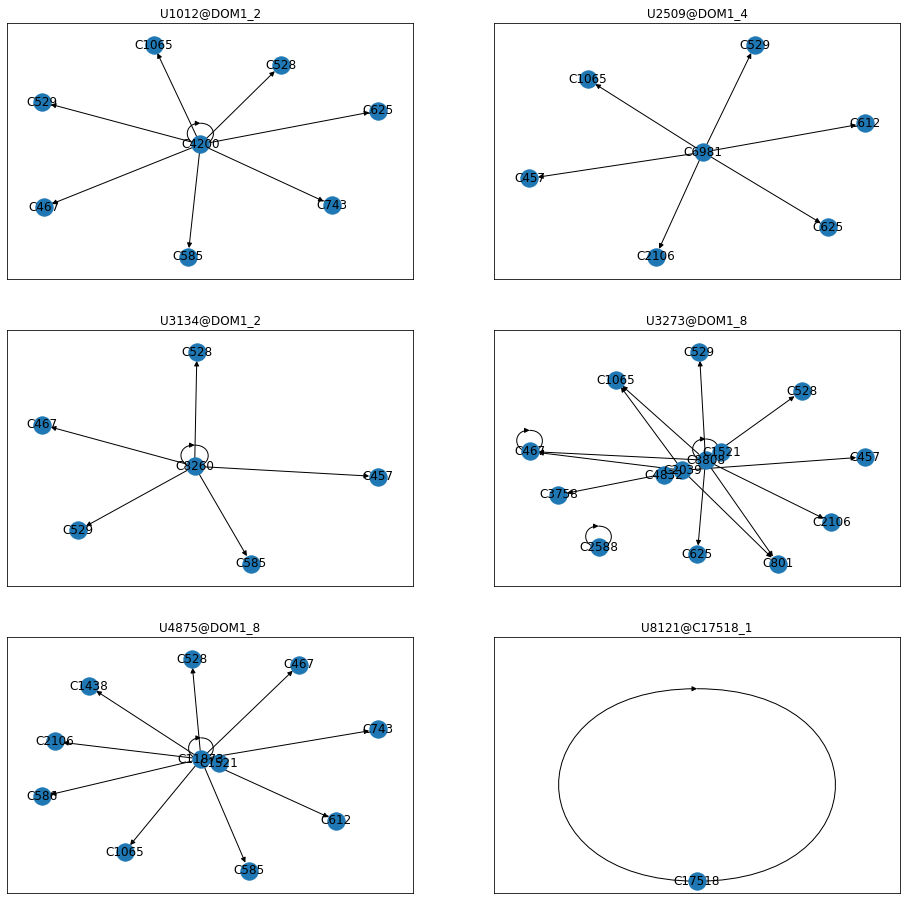

In [5]:
idents = pd.read_csv(                       # Read instance identifiers (user name + day)
    os.path.join(dir_path, 'idents.csv'),
    index_col=0)

idents.insert(
    1, 'username',
    idents['ident'].apply(lambda x: x.split('_')[0])
)
idents.insert(
    2, 'day',
    idents['ident'].apply(lambda x: int(x.split('_')[1]))
)

fig = plt.figure()
axes = fig.subplots(3, 2).flatten()
ids = [np.random.randint(0, idents.shape[0]) for j in range(6)]
for j, i in enumerate(ids):
    g = load_graph(idents.iloc[i,0])
    nx.draw_networkx(g, ax=axes[j])
    axes[j].set_title(idents.iloc[i,0])
fig.set_size_inches(16, 16)
plt.show()

Most authentication graphs are essentially star-like, which intuitively makes sense in a client-server paradigm: each user makes outbound connections from their workstation to several servers (such as filers, mail servers or domain controllers).
However, beware of oversimplifying assumptions: a lot of user accounts exhibit different behaviors, which do not result in nicely interpretable star graphs.
For instance, some local accounts only authenticate locally to their associated host, resulting in a graph with one node and one self-loop.
At the other end of the spectrum, some accounts authenticate from several source hosts to many destinations.
These could correspond to service accounts or domain administrators (though authenticating from several sources is a bad administrative practice).

Let's now take a look at some graphs corresponding to malicious user-days.

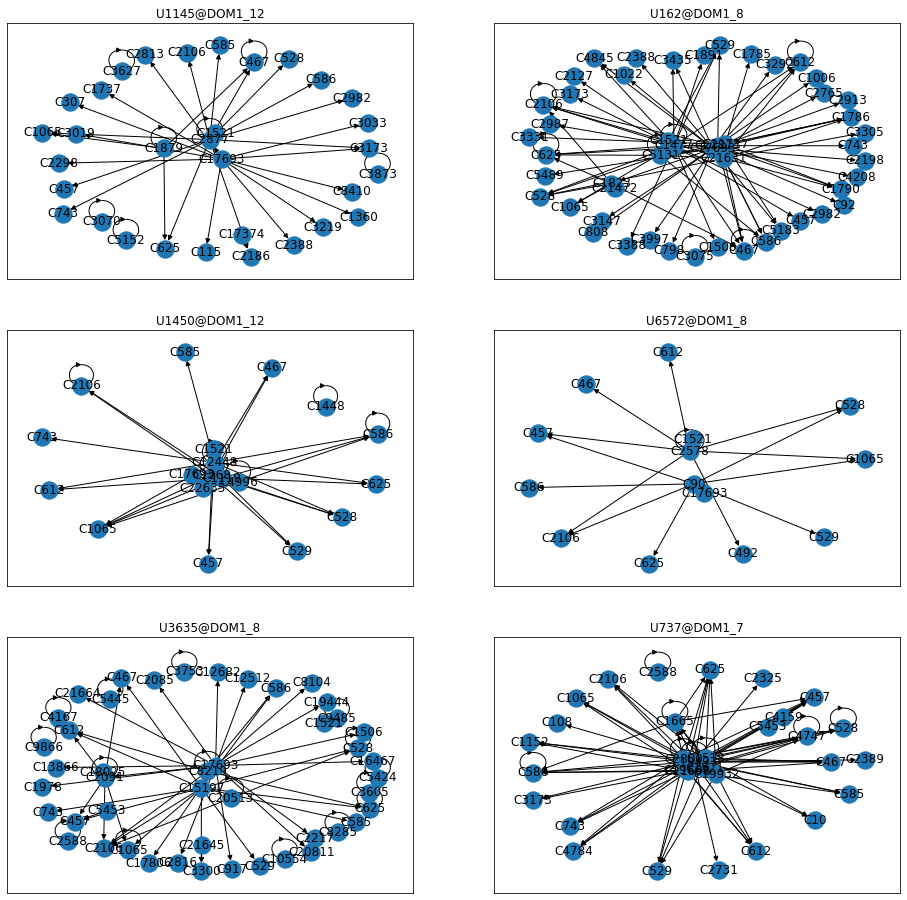

In [6]:
labels = pd.read_csv(                       # Read instance labels (0 for benign, 1 for malicious)
    os.path.join(dir_path, 'labels.csv'),
    index_col=0)
y = np.array(labels)[:,0]

fig = plt.figure()
axes = fig.subplots(3, 2).flatten()
mal_idx = np.where(y==1)[0]
ids = np.random.choice(mal_idx, size=(6,), replace=False)
for j, i in enumerate(ids):
    g = load_graph(idents.iloc[i,0])
    nx.draw_networkx(g, ax=axes[j])
    axes[j].set_title(idents.iloc[i,0])
fig.set_size_inches(16, 16)
plt.show()

Malicious graphs seem to be tendencially larger and more complex.
This is consistent with what we saw in the previous notebook: malicious user-days coincided with large feature values &mdash; in other words, high number of events and visited hosts.
Recall that this does not necessarily mean that large, complex authentication graphs are indicative of malicious behavior: for now, all we have is an apparent correlation.

While building a user's authentication graph is rather straightforward and intuitive, leveraging it for intrusion detection requires further thought.
Indeed, graphs are complex objects, and designing suitable tools to analyze and compare them is an active area of research.
In this notebook, we explore several graph-based intrusion detection methods.
We start with the simplest one, proposed in&nbsp;[KL13, KLN15]: first, each graph is converted to a fixed-size vector through manual feature extraction.
Usual anomaly detection methods can then be applied.

Whereas the features we used in the previous notebook were simple event counts and field arities, we can now leverage structural properties of authentication graphs to build more sophisticated metrics.
More specifically, we extract the following features:

* Number of nodes (`n_vertices`) and edges (`n_arcs`) in the graph
* Number of weakly connected components (`n_cc`); intuitively, a user authentication graph with several connected components looks suspicious and could result from the presence of an intruder exploring the network using stolen credentials.
* Entropy and maximum of the distribution of in- and out-degrees (`ent_in_degrees`, `max_in_degree`, `ent_out_degrees` and `max_out_degree`, respectively)
* Standard deviation and maximum of the distribution of edge weights (`std_weights` and `max_weight`, respectively)
* Diameter of the graph (`diameter`); intuitively, a high diameter could reveal malicious lateral movement of an intruder hopping from host to host.

In [7]:
# Feature generation
feature_vectors = Parallel(n_jobs=-1)(
    delayed(make_feature_vector)(ident)
    for ident in idents['ident'])
features = pd.DataFrame(feature_vectors, columns=feature_names)

X = np.array(features).astype(np.float64)

# Train-test split: first 8 days for training, next 5 days for testing
n_train = idents[idents['day']<8].shape[0]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=n_train, shuffle=False)

Now that each user-day is represented by a feature vector, let's go through the same steps as in the previous notebook, starting with some exploration.

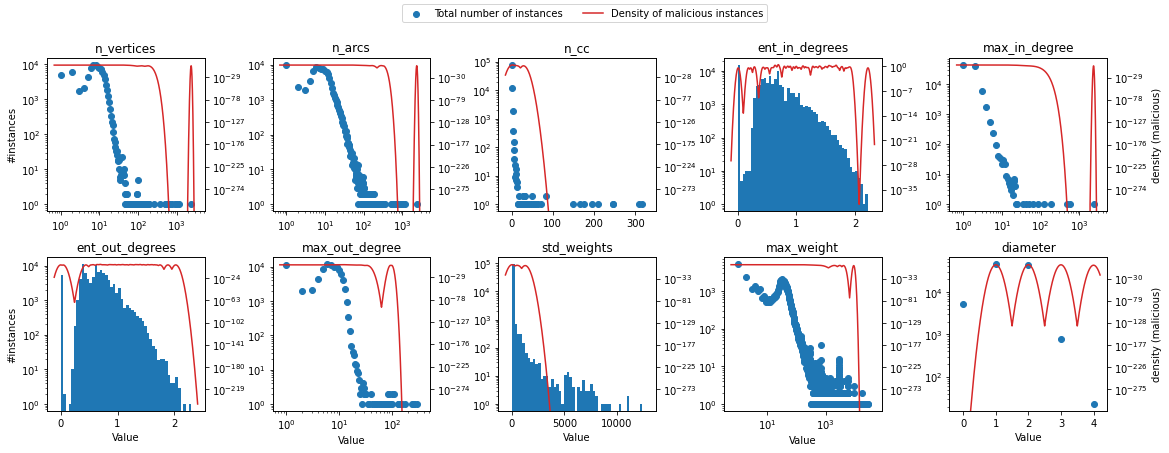

In [8]:
fig = plt.figure()
axes = fig.subplots(2, 5).flatten()
logscale = (0, 1, 4, 6, 8)
int_features = (0, 1, 2, 4, 6, 8, 9)
X_mal = X[y==1]
for i, col in enumerate(features):
    lines = []
    if i in int_features:
        val, cnt = np.unique(X[:,i], return_counts=True)
        lines.append(axes[i].scatter(val, cnt))
    else:
        axes[i].hist(X[:,i], bins=50)
    axes[i].set_title(col)
    if i in logscale:
        axes[i].loglog()
    else:
        axes[i].set_yscale('log')
    if i % 5 == 0:
        axes[i].set_ylabel('#instances')
    if i//5 == 1:
        axes[i].set_xlabel('Value')
    ax = axes[i].twinx()
    kde = KernelDensity(
        bandwidth=(X[:,i].max()-X[:,i].min())/200
        ).fit(X_mal[:,i,np.newaxis])
    xs = np.linspace(*ax.get_xlim(), 1000)
    lines.append(
        ax.plot(xs, np.exp(kde.score_samples(xs[:,np.newaxis])), color='tab:red')[0]
    )
    ax.set_yscale('log')
    if i % 5 == 4:
        ax.set_ylabel('density (malicious)')
fig.set_size_inches(19, 6.5)
fig.legend(
    handles=lines,
    labels=['Total number of instances', 'Density of malicious instances'],
    loc='upper center',
    ncol=2
)
plt.subplots_adjust(hspace=.3, wspace=.43)
plt.show()

Again, most features have long-tailed distributions.
Notice the high number of zero-diameter graphs, which correspond to accounts making only local authentications.
Another weird and quite unexpected behavior can be observed for the number of connected components, which can be as high as a few hundreds for several user-days.
This can be interpreted as generic admin or service accounts being used on many hosts to perform local operations.
As mentioned above, real-world data can stray pretty far away from the nice star-shaped client-server graph!

Now let's discuss correlations between these features.

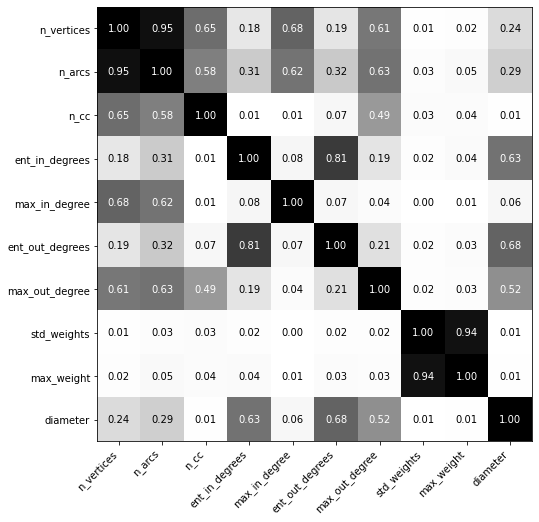

In [9]:
n, d = X_train.shape
corr = np.ones((d, d))
for i in range(d):
    for j in range(i):
        r, p = pearsonr(X[:,i], X[:,j])
        corr[i, j] = r
        corr[j, i] = r
fig = plt.figure()
plt.imshow(corr, cmap='Greys')
ax = plt.gca()
ax.set_xticks(np.arange(d))
ax.set_xticklabels(features.columns, rotation=45, ha='right')
ax.set_yticks(np.arange(d))
ax.set_yticklabels(features.columns)
colors = ['black', 'white']
for i in range(d):
    for j in range(d):
        ax.text(i, j, '{0:.2f}'.format(corr[i,j]),
            ha='center', va='center',
            color=colors[int(corr[i,j]>.4)])
fig.set_size_inches(8.2, 8)
plt.show()

The most significant correlations are rather sensible: in particular, more vertices necessarily means more edges, and it also seems logical that the maximum out degree and the number of connected components are positively correlated with the number of vertices.
Note, however, that some features are surprisingly independent from the others, such as the maximum in degree and the maximum edge weight.

Finally, let's see if dimensionality reduction reveals any underlying structure.

In [10]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

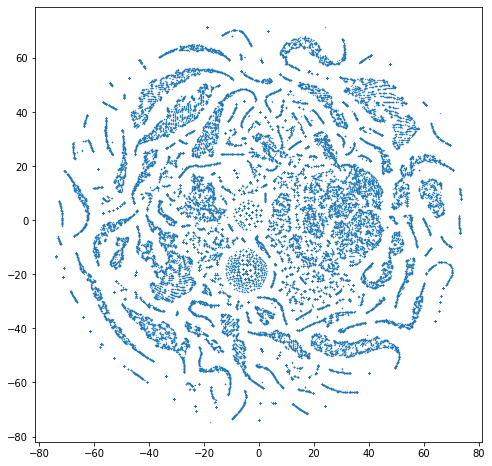

In [11]:
tsne = TSNE(n_components=2, random_state=seed, perplexity=30, n_jobs=-1)
X_emb = tsne.fit_transform(X_train_scaled)

fig = plt.figure()
plt.scatter(X_emb[:,0], X_emb[:,1], s=.1)
fig.set_size_inches(8, 8)
plt.show()

Instances seem slightly more clustered than in the previous notebook, but the number of outliers remains high, which is not particularly surprising.

It is now detection time again.
Since Isolation Forest worked best in the previous notebook, we also use this algorithm here.

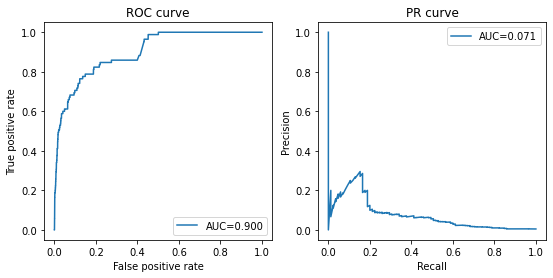

In [12]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

iforest = IsolationForest(random_state=seed).fit(X_train_scaled)
y_pred = 1-iforest.score_samples(X_test_scaled)                  # Complement to 1 for consistency with our labels
evaluate_algo(y_test, y_pred)

Detection performance is roughly similar to the one we obtained with simple count-based features.
Let's look at some false positives and negatives to see if the same patterns appear.

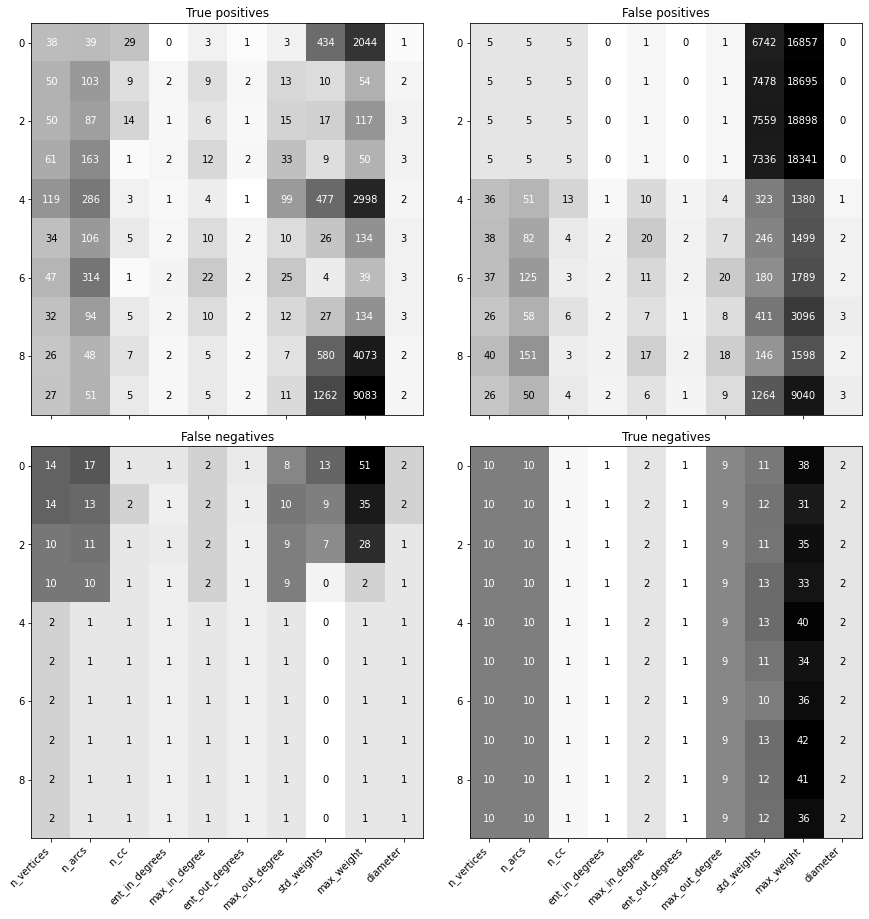

In [13]:
plot_examples(X_test, y_test, y_pred, features.columns)

Just like before, anomalous instances seem to be characterized by large feature values.
This can be confirmed by computing the SHAP values.

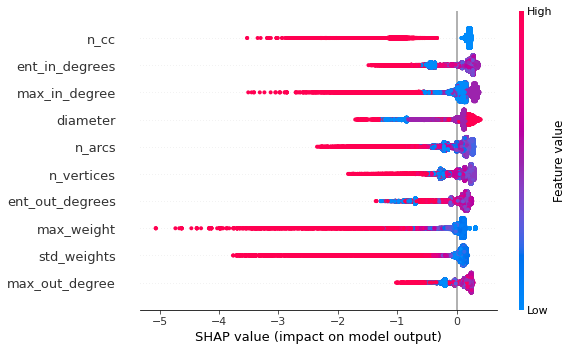

In [14]:
explainer = shap.TreeExplainer(
    iforest,
    feature_names=features.columns)
shap_val = explainer(X_test_scaled)
shap.plots.beeswarm(shap_val)

However, we can now get more details by directly visualizing the underlying graphs.
Once again, we plot true/false positives/negatives; misclassified instances are displayed in red while correctly classified ones are displayed in green, and the shape of the nodes relates to the true labels (triangles for malicious instances and circles for benign ones).

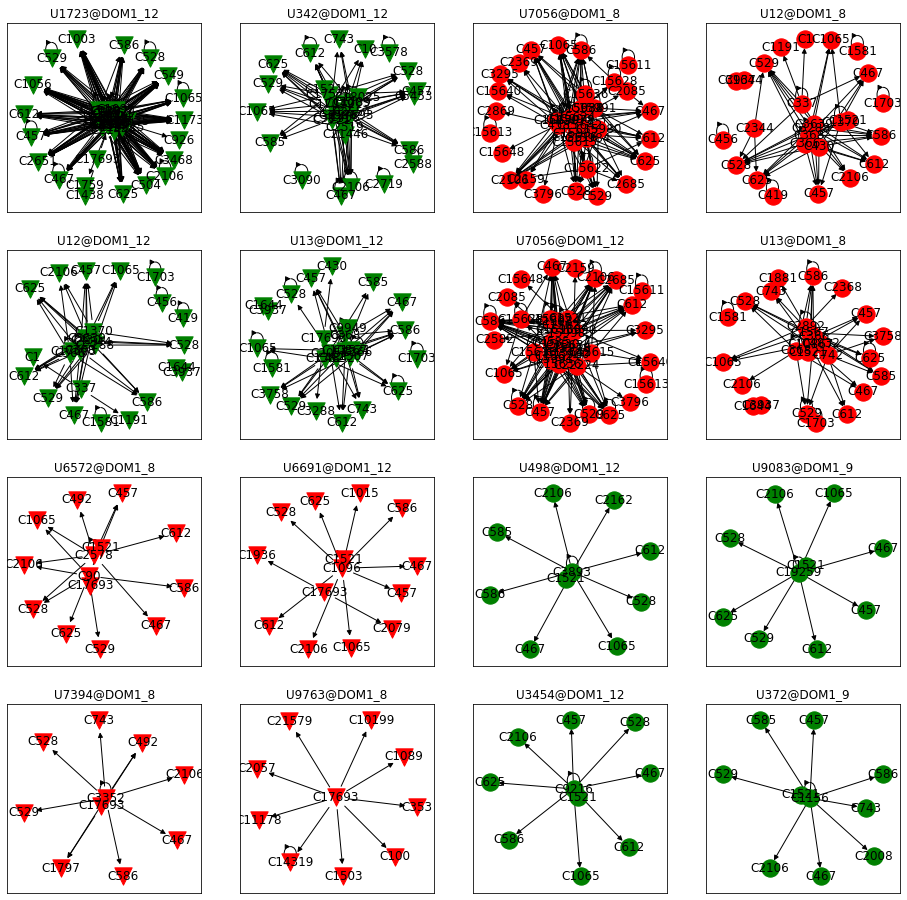

In [15]:
plot_graph_examples(y_test, y_pred, idents[idents['day']>=8], graphs_path)

The outcome is, once again, unsurprising: in terms of structure, true and false positives look rather similar, and the same goes for true and false negatives.
More specifically, large graphs with complex structures are identified as anomalous, while small and/or star-like graphs are considered normal.
This suggests that simply focusing on structural properties is a dead end: we need to leverage the labels associated with the nodes &mdash; in other words, the names of the corresponding hosts.

When dealing with labelled graphs, an interesting approach is the use of graph kernels.
Basically, a kernel is a (positive, semi-definite) similarity measure between instances.
What makes kernels especially useful is that a certain family of classification models, namely Support Vector Machines (SVM), can be built upon them without explicitly extracting any features.
In other words, instead of embedding objects of interest in a Euclidean space through feature extraction and defining similarity using standard distance metrics defined over this space, we can directly build a relevant similarity measure and use it for subsequent classification tasks.

A successful class of kernels for labelled graphs can be derived from the so-called Weisfeiler-Lehman (or Leman) graph kernel&nbsp;[SSV$^+$11].
This similarity metric draws inspiration from the Weisfeiler-Lehman graph isomorphism test&nbsp;[WL68], and it can be computed as follows.
Given a graph $G=(V,E)$ and a node labelling function $c:V\rightarrow\{1,\ldots,C\}$, new node labels are iteratively built by aggregating each node's current label with the ones of its neighbors.
Formally, this can be written as

$c^{(t)}(v)=\text{Hash}\bigg(c^{(t-1)}(v),\text{Sort}\big(\{c^{(t-1)}(u):u\in{N}(v)\}\big)\bigg),$

where $c^{(t)}(v)$ is $v$'s label at the $t$-th iteration and $N(v)$ is the neighborhood of $v$.
Note that this approach is straightforwardly extended to directed graph by defining the neighborhood of $v$ as the set of nodes with inbound edges coming from $v$.
After $T$ iterations of this aggregation step, the number of occurrences of each existing label in $G$ can be seen as a signature of $G$.
The Weisfeiler-Lehman graph kernel can then be defined by comparing the signatures of the two input graphs.

The main remaining question then lies in the definition of the labelling function $c$.
In the case of authentication graphs, a straightforward choice is to label each node with the underlying host's name.
However, we will also explore other possibilities.

In [16]:
def build_graph_set(idx, idents, labels=None):
    # Helper function that builds a list of grakel-compatible graphs.
    g_nx = []
    for i in idx:
        g = load_graph(idents.loc[i, 'ident'])
        for n in g.nodes:
            if labels is None:
                g.nodes[n]['lab'] = n
            else:
                g.nodes[n]['lab'] = labels[n]
        g_nx.append(g)
    return list(gk.utils.graph_from_networkx(g_nx, node_labels_tag='lab'))

# The main limitation here is space complexity: building an OCSVM with
# a precomputed kernel requires storing big Gram matrices.
# Thus we subsample the training set to restrain memory consumption.
n_samp = 10000
G_train = build_graph_set(
    np.random.choice(np.arange(n_train), n_samp, replace=False),
    idents
)

Since we're interested in unsupervised anomaly detection, we'll use a specific kind of SVM, namely the One Class SVM (OCSVM).
The processing pipeline then entails three main steps: first, we precompute a Weisfeiler-Lehman kernel matrix on the subsampled training set.
We then train an OCSVM using this matrix.
The anomaly score of a test sample is then obtained by evaluating the kernel value between this sample and each of the training samples, then feeding these values to the trained OCSVM.

The main hyperparameter is the number of Weisfeiler-Lehman iterations involved in the computation of the kernel.
Intuitively, more iterations make the kernel more expressive by capturing more complex substructures.
However, besides the additional computational overhead, an increased number of iterations can lead to very high-dimensional and sparse graph signatures, which can in turn degrade detection performance.

In [17]:
def evaluate_gk(
    G_train, n_train, idents, y_test,
    n_iter=(3, 4, 5), step=5000, labels_test=None):
    y_pred = []
    for k in n_iter:
        wl = gk.WeisfeilerLehman(n_jobs=-1, n_iter=k, normalize=True)
        ocsvm = OneClassSVM(kernel='precomputed')
        K = wl.fit_transform(G_train)
        ocsvm.fit(K)
        
        tmp = []
        for i in range(n_train, idents.shape[0], step):
            G_test = build_graph_set(
                np.arange(i, min(i+step, idents.shape[0])),
                idents,
                labels=labels_test
            )
            K = wl.transform(G_test)
            tmp.append(1-ocsvm.decision_function(K))
        y_pred.append(np.concatenate(tmp))
    y_pred = np.stack(y_pred, axis=1)
    evaluate_algo(y_test, y_pred, names=['{0} WL iterations'.format(k) for k in n_iter])
    return y_test, y_pred

First of all, let's try with the default node labels &mdash; that is, the names of the hosts associated with the nodes.

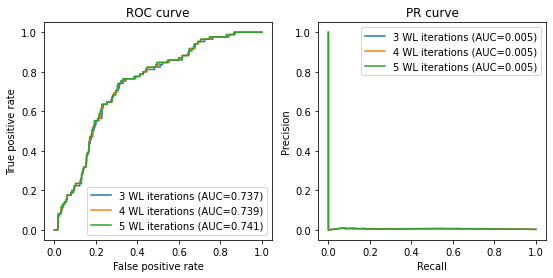

In [18]:
y_test, y_pred = evaluate_gk(G_train, n_train, idents, y_test)

How disappointing.
Let's investigate further.

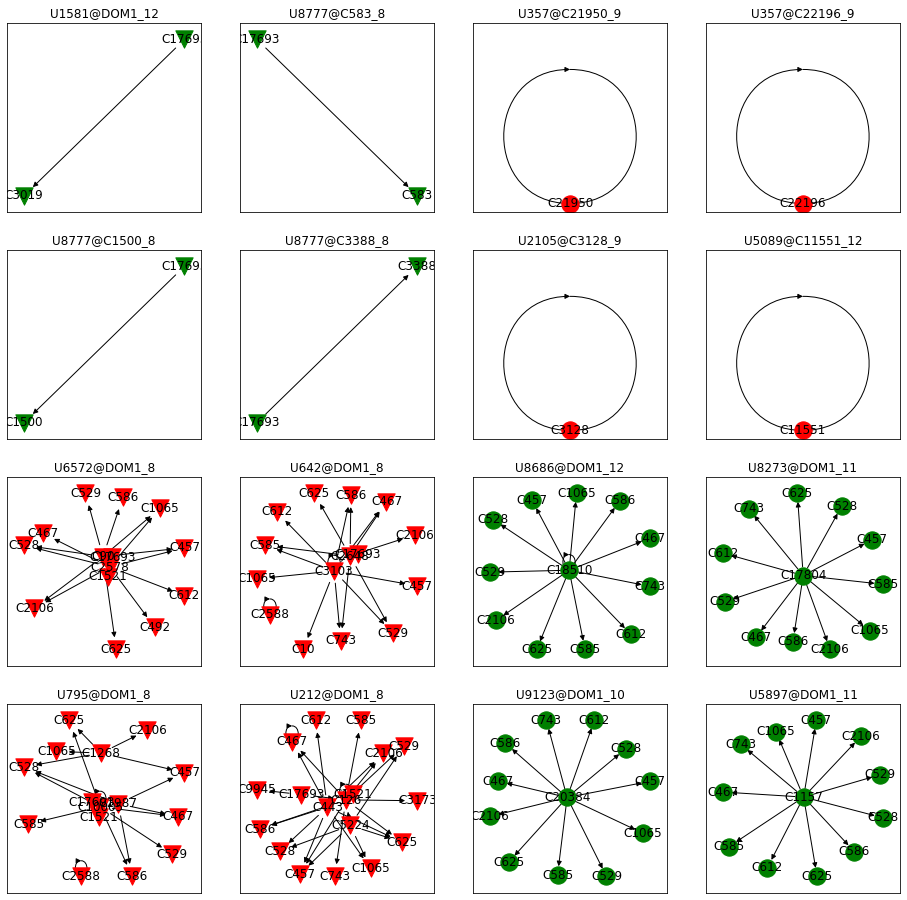

In [19]:
plot_graph_examples(y_test, y_pred[:,-1], idents[idents['day']>=8], graphs_path)

Interestingly, the results seem qualitatively different from those obtained through numeric feature extraction: anomalous graphs are now small and simple ones.
This actually makes sense given the definition of the kernel: considering for instance a graph with two nodes $u,v$ and one directed edge $(u,v)$, the generated labels will be $\{u,v,(u,v),((u,v),v),...\}$.
These labels are rather specific and yield sparse signatures, making the underlying graphs dissimilar to the training samples.

To make the kernel less specific, we need to define more generic node labels.
We will do so by leveraging the structure of the global user-host authentication graph.
More specifically, we build a bipartite graph $B$ whose nodes are the users and hosts seen in the training set.
An edge is then added between user $U$ and host $H$ if there is an authentication event involving both $U$ and $H$ in the training set.

In [20]:
B = nx.Graph()
for i, x in idents[idents['day']<8].iterrows():
    g = load_graph(x['ident'])
    B.add_edges_from([(x['ident'].split('_')[0], n) for n in g.nodes()])

How can we then build node labels using the graph $B$?
Basically, what we need is a node-wise metric whose distribution can be summarized as a histogram.
A straightforward candidate is the degree, which can be seen as a rough characterization of each host's role in the network: domain controllers can be expected to have the highest degrees (i.e., to be logged on to by many users), followed by applicative servers and workstations.

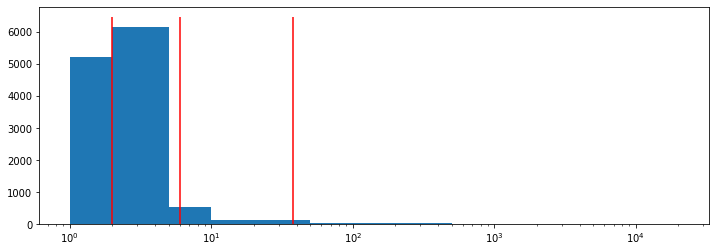

In [21]:
deg = [B.degree(n) for n in B.nodes() if n.startswith('C')]
bins = np.concatenate([(10**i)*np.array([1, 2, 5]) for i in range(5)])
plt.hist(deg, bins=bins[:-1])
qtl = np.quantile(deg, (.5, .95, .99))
vmin, vmax = plt.gca().get_ylim()
for q in qtl:
    plt.vlines(q, vmin, vmax, color='red')
plt.xscale('log')
plt.gcf().set_size_inches(12, 4)

The shape of the histogram is as expected: many hosts are authenticated to by few users, and conversely.
The red lines indicate the position of some quantiles of the degree distribution.
These quantiles should be chosen so as to delimit meaningful bins; each node in the user authentication graphs can then be labelled using the index of the bin it falls into.

In [22]:
def build_degree_hist(idents, quantiles=(.5, .95, .99)):
    B = nx.Graph()
    for i, x in idents.iterrows():
        g = load_graph(x['ident'])
        B.add_edges_from([(x['ident'].split('_')[0], n) for n in g.nodes()])
    hosts = [n for n in B.nodes() if n.startswith('C')]
    degrees = [B.degree(h) for h in hosts]
    q = np.concatenate([np.quantile(degrees, quantiles), [np.inf]])
    hist = dict(zip(hosts, [min(np.where(q>degrees[i])[0]) for i in range(len(hosts))]))
    return hist

Having defined new node labels, we can now assess their effectiveness at detecting malicious authentication graphs using the Weisfeiler-Lehman graph kernel.

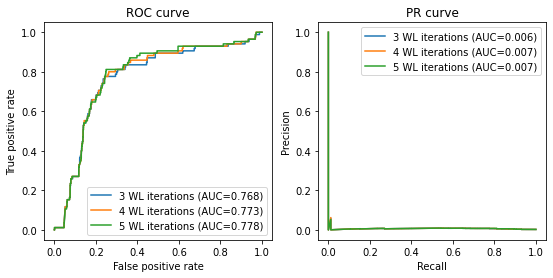

In [23]:
degree_hist_train = build_degree_hist(idents[idents['day']<8])
G_train = build_graph_set(
    np.random.choice(np.arange(n_train), n_samp, replace=False),
    idents,
    labels=degree_hist_train
)
degree_hist_test = build_degree_hist(idents[idents['day']>=8])
y_test, y_pred = evaluate_gk(G_train, n_train, idents, y_test, labels_test=degree_hist_test)

Slightly better, but still bad.
Let's see if the nature of right and wrong predictions has changed.

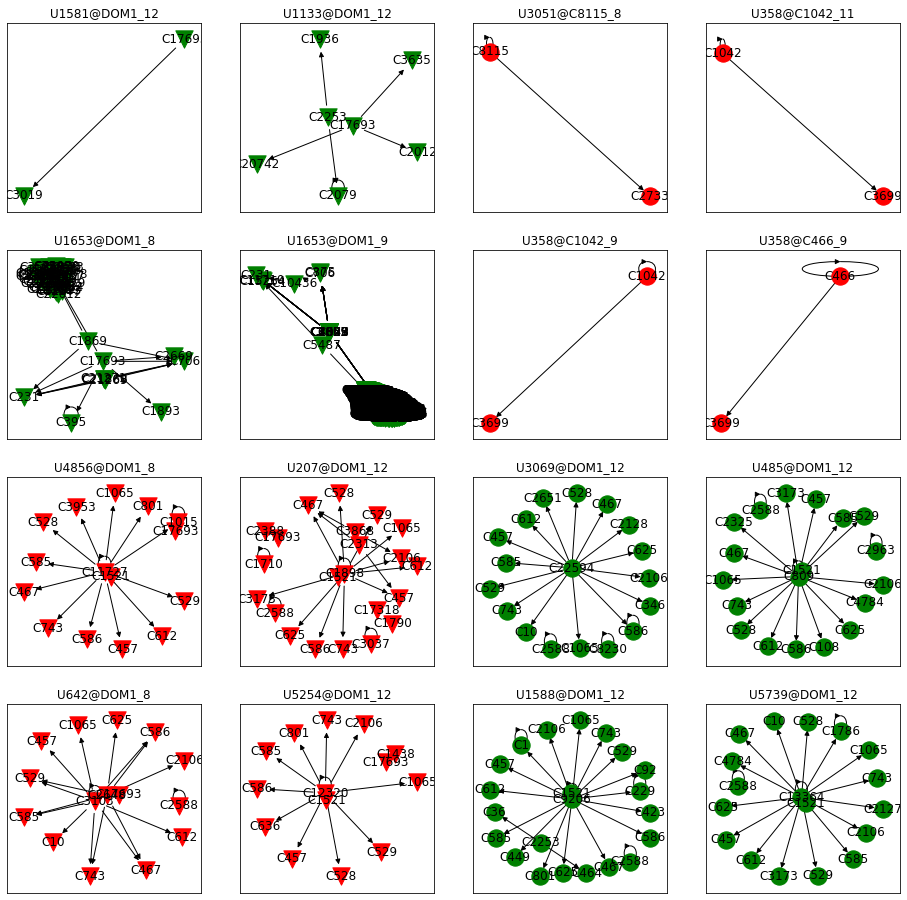

In [24]:
plot_graph_examples(y_test, y_pred[:,-1], idents[idents['day']>=8], graphs_path)

Interestingly, more complex graphs are now detected as malicious.
However, false positives are still related to local accounts with peculiarly small authentication graphs.
As for false negatives, they essentially look like standard, star-like client-server graphs, with small modifications related to malicious activity.
In particular, host C17693 happens to be a compromised host which is involved in many red team events.
For some of the false negatives, we can see a small connected component containing this host.
From the perspective of the Weisfeiler-Lehman kernel, this added component does not make a big difference, which explains why downstream anomaly detection algorithms cannot detect it.
Once again, user-based aggregation seems too coarse to provide interesting insights.

Other node-wise metrics can be used as well.
For instance, let's take a look at the PageRank importance measure&nbsp;[PBMW99].

In [25]:
pgrk = nx.algorithms.link_analysis.pagerank_alg.pagerank(B)

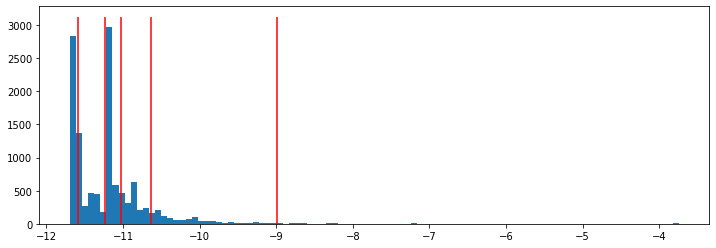

In [26]:
val = np.log([pgrk[k] for k in pgrk if k.startswith('C')])
plt.hist(val, bins=100)
qtl = np.quantile(val, (.3, .45, .75, .9, .99))
vmin, vmax = plt.gca().get_ylim()
for q in qtl:
    plt.vlines(q, vmin, vmax, color='red')
plt.gcf().set_size_inches(12, 4)

In [27]:
def build_pagerank_hist(idents, quantiles=(.3, .45, .75, .9, .99)):
    B = nx.Graph()
    for i, x in idents.iterrows():
        g = load_graph(x['ident'])
        B.add_edges_from([(x['ident'].split('_')[0], n) for n in g.nodes()])
    hosts = [n for n in B.nodes() if n.startswith('C')]
    pgrk = nx.algorithms.link_analysis.pagerank_alg.pagerank(B)
    pgrk_hosts = [pgrk[h] for h in hosts]
    q = np.concatenate([np.quantile(pgrk_hosts, quantiles), [np.inf]])
    hist = dict(zip(hosts, [min(np.where(q>pgrk_hosts[i])[0]) for i in range(len(hosts))]))
    return hist

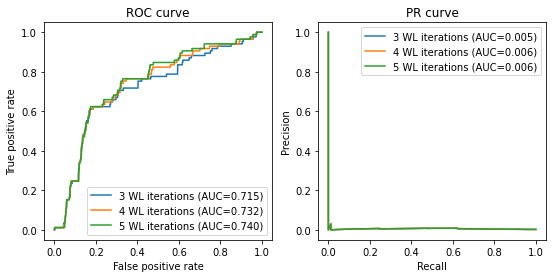

In [28]:
pgrk_hist_train = build_pagerank_hist(idents[idents['day']<8])
G_train = build_graph_set(
    np.random.choice(np.arange(n_train), n_samp, replace=False),
    idents,
    labels=pgrk_hist_train
)
pgrk_hist_test = build_pagerank_hist(idents[idents['day']>=8])
y_test, y_pred = evaluate_gk(G_train, n_train, idents, y_test, labels_test=pgrk_hist_test)

That's actually worse.
What about the qualitative side?

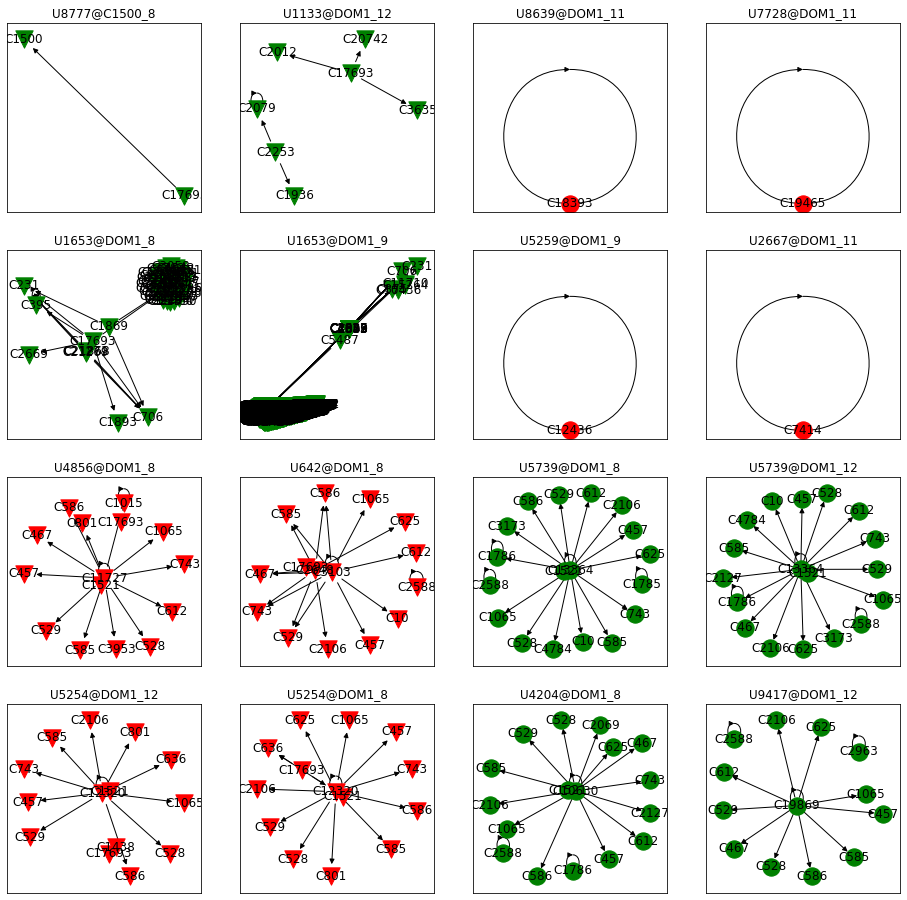

In [29]:
plot_graph_examples(y_test, y_pred[:,-1], idents[idents['day']>=8], graphs_path)

We essentially get the same kind of results as before.
Overall, it seems like we should stop focusing on user behavior and adopt a finer-grained perspective.
This is the main focus of the next notebooks.

### Further reading

Authentication graphs have received a fair share of attention in recent years.
Besides contributions aiming to detect compromised user accounts by analyzing the corresponding graph as a whole, some proposed methods also work at a finer granularity.
For instance, Powell&nbsp;[Pow20] computes handcrafted features for the nodes of all the authentication graphs of a given user, then uses these features to detect anomalous authentications (corresponding to anomalous nodes).

More generally, designing statistical analysis and machine learning tools for graphs has been a very active research topic in the last two decades.
Since the complex structure of graphs, as well as the various possible kinds of side information (node labels or features, edge weights or types, etc.), are not easily described through basic feature extraction approaches, a significant amount of literature seeks to define distances and kernels for graph comparison.
The Weisfeiler-Lehman graph kernel framework has achieved state-of-the-art performance for a number of tasks, but alternatives have also been proposed.
The most notable ones include structure2vec&nbsp;[DDS16], which fits a random graph model to each considered graph and uses an embedding of the fitted model to define the kernel.
Connections to various other fields, such as optimal transport&nbsp;[PECF19] or topological data analysis&nbsp;[ORB21], have been explored as well.
A transition towards the deep learning paradigm also seems to be taking place, with the use of Graph Neural Networks (GNN) for graph representation yielding state-of-the-art results for various applications; see for instance&nbsp;[BBCV21] for a discussion of recent advances in this domain.


### References

[BBCV21] Michael Bronstein, Joan Bruna, Taco Cohen, and Petar Veličković. _Geometric Deep Learning: Grids, Groups, Graphs, Geodesics and Gauges_, 2021.

[DDS16] Hanjun Dai, Bo Dai, and Le Song. Discriminative Embeddings of Latent Variable Models for Structured Data. In _ICML_, 2016.

[KL13] Alexander Kent and Lorie Liebrock. Differentiating User Authentication Graphs. In _S&P Workshops_, 2013.

[KLN15] Alexander Kent, Lorie Liebrock, and Joshua Neil. Authentication Graphs: Analyzing User Behavior within an Enterprise Network. _Computers & Security_, 48:150&ndash;166, 2015.

[ORB21] Leslie O'Bray, Bastian Rieck, and Karsten Borgwardt. Filtration Curves for Graph Representation. In _KDD_, 2021.

[PBMW99] Lawrence Page, Sergey Brin, Rajeev Motwani and Terry Winograd. _The PageRank Citation Ranking: Bringing Order to the Web_. Stanford Infolab, 1999.

[PECF19] Hermina Petric Maretic, Mireille El Gheche, Giovanni Chierchia, and Pascal Frossard. GOT: An Optimal Transport Framework for Graph Comparison. In _NeurIPS_, 2019.

[Pow20] Brian Powell. Detecting Malicious Logins as Graph Anomalies. _Journal of Information Security and Applications_, 54:102557, 2020.

[SSV$^+$11] Nino Shervashidze, Pascal Schweitzer, Erik Jan van Leeuwen, Kurt Mehlhorn, and Karsten Borgwardt. Weisfeiler-Lehman Graph Kernels. _Journal of Machine Learning Research_, 12(Sep):2539&ndash;2561, 2011.

[WL68] Boris Weisfeiler and Andrei Leman. The Reduction of a Graph to Canonical Form and the Algebra which Appears Therein. _NTI, Series_, 2(9):12&ndash;16, 1968.
